In [24]:
# Data Analysis
import pandas as pd
import numpy as np
import math

import pingouin as pg
import scipy.stats as stats

# Bioinformatics
from pysam import VariantFile

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec

# Store data
import bz2 as bz2
import pickle

mpl.rcParams['figure.dpi'] = 300

In [2]:
# Generations
generations = {
    "ancestor": 0,
    "D2B3": 84, # has a 50G
    "D2B3_50G": 50,
    "D5C3": 81, # has a 50G
    "D5C3_50G": 45,
    "D2C1": 79, # has a 50G
    "D2C1_50G": 49,
    "D2C3": 75, # has a 50G
    "D2C3_50G": 42,
    "D3A3": 84,  # has a 50G
    "D3A3_50G": 49,
    "D4B4": 87, # has a 50G
    "D4B4_50G": 51,
    "D5C1": 79, # has a 50G
    "D5C1_50G": 45,
    "H4A4": 118, # has a 50G
    "H4A4_50G": 61,
    "H5A2": 132, # has a 50G
    "H5A2_50G": 68,
    "H2B4": 119, # has a 50G
    "H2B4_50G": 62, # LOW COVERAGE SAMPLE
    "H3A4": 129, # has a 50G
    "H3A4_50G": 65,
    "H3C4": 133, # has a 50G
    "H3C4_50G": 68,
    "H5A4": 131, # has a 50G
    "H5A4_50G": 67,
    "H5C2": 125, # has a 50G
    "H5C2_50G": 62,
    "H2A3":117,
    "H2C3":122,
    "H5A3":128,
    "H4C2":128,
    "D4A3":82,
    "D5B3":83,
    "D3A1":87,
    "D2A1":86,
}

median_coverage = {
    "ancestor": 341,
    "D2A1": 47,
    "D2B3": 264, # has a 50G
    "D2B3_50G": 408,
    "D2C1": 110, # has a 50G
    "D2C1_50G": 137,
    "D2C3": 106, # has a 50G
    "D2C3_50G": 118,
    "D3A1": 49,
    "D3A3": 105,  # has a 50G
    "D3A3_50G": 177,
    "D4A3": 54,
    "D4B4": 144, # has a 50G
    "D4B4_50G":176,
    "D5B3": 73,
    "D5C1": 120, # has a 50G
    "D5C1_50G": 127,
    "D5C3": 156, # has a 50G
    "D5C3_50G": 194,
    "H2A3": 449,
    "H2B4": 122, # has a 50G
    "H2B4_50G": 27, # LOW COVERAGE SAMPLE
    "H2C3": 148,
    "H3A4": 90, # has a 50G
    "H3A4_50G": 150,
    "H3C4": 127, # has a 50G
    "H3C4_50G": 111,
    "H4A4": 409, # has a 50G
    "H4A4_50G": 404,
    "H4C2": 204,
    "H5A2": 54, # has a 50G
    "H5A2_50G": 63,
    "H5A3": 202,
    "H5A4": 126, # has a 50G
    "H5A4_50G": 131,
    "H5C2": 148, # has a 50G
    "H5C2_50G": 165,
    
    "30H_C3_E4":  199,
    "30H_C3_E5":  209,
    "30H_C36_E5": 244,
    "30H_C48_E5": 275,
    
    "30D_C13_E3": 259,
    "30D_C38_E4": 193,
    "30D_C38_E5": 236,
    "30D_C52_E5": 208,
    
    "P0_C9_E4":   186,
    "P0_C9_E5":   174,
    "P0_C27_E5":  242,
    "P0_C40_E5":  192,
    
    "P100_C8_E3": 413,
    "P100_C8_E4": 431,
    "P100_C30_E3":424,
    "P100_C30_E4":490,
    
    "P250_C8_E3": 390,
    "P250_C8_E4": 334,
    "P250_C17_E3":354,
    "P250_C17_E4":435,
    
    "P500_C16_E4":185,
    "P500_C16_E5":187,
    "P500_C18_E3":291,
    "P500_C30_E3":275,
}

default_colors = [
    [31/255,119/255,180/255], # blue
    [255/255,127/255,14/255], # orange
    [44/255,160/255,44/255], # green
    [214/255, 39/255, 40/255], #
    [148/255, 103/255, 189/255], #
    [140/255, 86/255, 75/255],
    [227/255, 119/255, 194/255],
    [127/255, 127/255, 127/255],
    [188/255, 189/255, 34/255],
    [23/255, 190/255, 207/255],
]

# LENGTHS OF CHROMOSOMES
reference = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/input/reference.fa"
fai = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/input/reference.fa.fai"
lengths = {}
for line in open(fai, 'r') :
    s = line.strip().split()
    lengths[s[0]] = int(s[1])

bcf = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/genotype_allsamples/merged.only_het.gets.bcf"

### Read BCF and store data

In [5]:
all_dfs = {}

for sample in generations.keys() :
    print("---", sample, "---")
    bcf_in = VariantFile(bcf)  # auto-detect input format
    bcf_in.subset_samples([sample])
    
    dc = {"ref":[], "pos":[], "qual":[], "QD":[], "ALS":[], "GT":[], "GQ":[], "SH":[], "HET":[], "DP":[], "AF":[]}
    
    for i, rec in enumerate(bcf_in) :
        if i % 250000 == 0 :
            print("{} records elapsed...".format(i))

        al = list(set(rec.samples[sample]["GT"]))
        try :
            is_het = True if al[0] != al[1] else False
        except :
            is_het = False

        dc["ref"].append(rec.chrom)
        dc["pos"].append(rec.pos)
        dc["qual"].append(rec.qual)
        dc["ALS"].append(rec.alleles)
        dc["QD"].append(rec.info["QD"])
        dc["HET"].append(is_het)

        sm = rec.samples[sample]
        dp = sm["DP"]
        num_al = len(set(sm["GT"]))
        freq = 0.0
        try :
            min_al_dp = min(sm["AD"])
            freq = min_al_dp/dp
        except :
            freq = None

        dc["DP"].append(dp)
        dc["AF"].append(freq)
        dc["GQ"].append(sm["GQ"])
        dc["SH"].append(sm["SH"])
        dc["GT"].append(sm["GT"])
    
    #for k, v in dc.items() :
    #    print(k, len(v))
    all_dfs[sample] = pd.DataFrame().from_dict(dc)
    bcf_in.close()

--- ancestor ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- D2B3 ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- D2B3_50G ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- D5C3 ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- 

--- D4A3 ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- D5B3 ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- D3A1 ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...
--- D2A1 ---
0 records elapsed...
250000 records elapsed...
500000 records elapsed...
750000 records elapsed...
1000000 records elapsed...
1250000 records elapsed...
1500000 records elapsed...
1750000 records elapsed...
2000000 records elapsed...


### Save to pickle

In [6]:
with bz2.BZ2File("ME_heterozygosity_per_sample.pbz2".format(sample), 'wb') as f:
        pickle.dump(all_dfs, f)

In [7]:
all_dfs["D2A1"].head(100000).tail(3)

,ref,pos,qual,QD,ALS,GT,GQ,SH,HET,DP,AF
99997,Chrom_3,3833150,108367.0,19.02,"(T, C)","(0, 1)",99.0,36,True,33.0,0.393939
99998,Chrom_3,3833224,80856.5,13.86,"(T, G)","(0, 1)",99.0,36,True,38.0,0.421053
99999,Chrom_3,3833248,77685.5,13.16,"(T, A)","(0, 1)",99.0,36,True,37.0,0.432432


### Read pickle dataframe

In [6]:
all_dfs = None
with bz2.BZ2File("ME_heterozygosity_per_sample.pbz2", "rb") as f:
    all_dfs = pickle.load(f)

In [7]:
all_dfs["D2A1"].head(100000).tail(3)

,ref,pos,qual,QD,ALS,GT,GQ,SH,HET,DP,AF
99997,Chrom_3,3833150,108367.0,19.02,"(T, C)","(0, 1)",99.0,36,True,33.0,0.393939
99998,Chrom_3,3833224,80856.5,13.86,"(T, G)","(0, 1)",99.0,36,True,38.0,0.421053
99999,Chrom_3,3833248,77685.5,13.16,"(T, A)","(0, 1)",99.0,36,True,37.0,0.432432


# Filtering datasets

### Filters:
- **0.35 <= AF <= 0.65**
- **25% <= DP <= 1000% (in % of median DP)**

#### Get samples midpoint and endpoint 

In [8]:
data_50G_raw = []
data_50G_fil = []
data_100G_raw = []
data_100G_fil = []

maxdp = 10 * median_coverage["ancestor"]
mindp = 0.25 * median_coverage["ancestor"]
ancestor_raw = len(all_dfs["ancestor"].query("HET"))
ancestor_fil = len(all_dfs["ancestor"].query("HET & AF >= 0.35 & AF <= 0.65 & DP <= @maxdp & DP >= @mindp"))

samples = ["D2B3","D5C3","D2C1","D2C3","D3A3","D4B4","D5C1","H4A4","H5A2","H2B4","H3A4","H3C4","H5A4","H5C2",]

for sample in samples :
    
    df = all_dfs[sample]
    maxdp = 10 * median_coverage[sample]
    mindp = 0.25 * median_coverage[sample]
    data_100G_raw.append(len(df.query("HET"))/ancestor_raw)
    data_100G_fil.append(len(df.query("HET & AF >= 0.35 & AF <= 0.65 & DP <= @maxdp & DP >= @mindp"))/ancestor_fil)
    
    sample = sample + "_50G"
    df = all_dfs[sample]
    maxdp = 10 * median_coverage[sample]
    mindp = 0.25 * median_coverage[sample]
    data_50G_raw.append(len(df.query("HET"))/ancestor_raw)
    data_50G_fil.append(len(df.query("HET & AF >= 0.35 & AF <= 0.65 & DP <= @maxdp & DP >= @mindp"))/ancestor_fil)

H_mid_fil = []
H_end_fil = []

D_mid_fil = []
D_end_fil = []
for sm, mid, end in zip(samples, data_50G_fil, data_100G_fil) :
    if sm.startswith("H") :
        H_mid_fil.append(mid)
        H_end_fil.append(end)
    elif sm.startswith("D") :
        D_mid_fil.append(mid)
        D_end_fil.append(end)
    else :
        print(sm)

In [9]:
print("Midpoint:", data_50G_fil, "\n")
print("Endpoint:", data_100G_fil, "\n")
print("H midpoint:", H_mid_fil, "\n")
print("H endpoint:", H_end_fil, "\n")
print("D midpoint:", D_mid_fil, "\n")
print("D endpoint:", D_end_fil, "\n")

Midpoint: [0.9862607716299647, 0.9009741142520854, 0.9961149022200041, 0.9918437115191034, 1.0054028840355713, 1.0037932572103911, 0.996219431289357, 0.994206793543608, 0.9285595169186038, 0.769579865646914, 0.9965741050680285, 0.9912225792457231, 0.9965765219251234, 1.0020059913887382] 

Endpoint: [0.9608571867058359, 0.8921121034994882, 0.9333618119661011, 0.9850795327248493, 0.9901247219103805, 0.9981082051089942, 0.993991693262165, 0.9214418727742256, 0.8680456447630936, 0.9667960088021935, 0.9743613757233955, 0.9966611119234436, 0.9865320638388633, 1.0001238639261119] 

H midpoint: [0.994206793543608, 0.9285595169186038, 0.769579865646914, 0.9965741050680285, 0.9912225792457231, 0.9965765219251234, 1.0020059913887382] 

H endpoint: [0.9214418727742256, 0.8680456447630936, 0.9667960088021935, 0.9743613757233955, 0.9966611119234436, 0.9865320638388633, 1.0001238639261119] 

D midpoint: [0.9862607716299647, 0.9009741142520854, 0.9961149022200041, 0.9918437115191034, 1.005402884035571

#### Get samples with endpoint only

In [10]:
endpoint_only_samples = [
    "D4A3","D5B3","D3A1","D2A1",
    "H2A3","H2C3","H5A3","H4C2",
]

H_endpoint_val = []
D_endpoint_val = []

for sample in endpoint_only_samples :
    
    df = all_dfs[sample]
    maxdp = 10 * median_coverage[sample]
    mindp = 0.25 * median_coverage[sample]
    
    average_value = len(df.query("HET & AF >= 0.35 & AF <= 0.65 & DP <= @maxdp & DP >= @mindp"))/ancestor_fil
    
    if sample.startswith("H") :
        H_endpoint_val.append(average_value)
    elif sample.startswith("D") :
        D_endpoint_val.append(average_value)

print("Filtered hets:")
print("H samples end only:", H_endpoint_val, "\n")
print("D samples end only:", D_endpoint_val, "\n")

Filtered hets:
H samples end only: [1.0060173699519408, 0.9765510482513434, 1.0018223102495285, 0.9895658237071929] 

D samples end only: [0.9110342819094621, 0.942254637646658, 0.891087960305539, 0.8827214052573893] 



### Set data

In [11]:
H_samples_end = ["H2A3","H2C3","H5A3","H4C2"]
H_end_only = [1.0060173699519408, 0.9765510482513434, 1.0018223102495285, 0.9895658237071929]

D_samples_end = ["D4A3","D5B3","D3A1","D2A1"]
D_end_only = [0.9110342819094621, 0.942254637646658, 0.891087960305539, 0.8827214052573893]

H_samples_both = ["H4A4","H5A2","H2B4","H3A4","H3C4","H5A4","H5C2"]
H_mid = [0.994206793543608, 0.9285595169186038, 0.769579865646914, 0.9965741050680285, 0.9912225792457231, 0.9965765219251234, 1.0020059913887382]
H_end = [0.9214418727742256, 0.8680456447630936, 0.9667960088021935, 0.9743613757233955, 0.9966611119234436, 0.9865320638388633, 1.0001238639261119]

D_samples_both = ["D2B3","D5C3","D2C1","D2C3","D3A3","D4B4","D5C1"]
D_mid = [0.9862607716299647, 0.9009741142520854, 0.9961149022200041, 0.9918437115191034, 1.0054028840355713, 1.0037932572103911, 0.996219431289357]
D_end = [0.9608571867058359, 0.8921121034994882, 0.9333618119661011, 0.9850795327248493, 0.9901247219103805, 0.9981082051089942, 0.993991693262165]

### Average heterozygosity

In [12]:
print("Average at midpoint (both): {:.2f}%".format(sum(D_mid+H_mid)*100/len(D_mid+H_mid)))
print("Average at endpoint (both): {:.2f}%".format(sum(D_end+H_end+D_end_only+H_end_only)*100/len(D_end+H_end+D_end_only+H_end_only)))
print("")
print("Average at midpoint (hydrated): {:.2f}%".format(sum(H_mid)*100/len(H_mid)))
print("Average at endpoint (hydrated): {:.2f}%".format(sum(H_end+H_end_only)*100/len(H_end+H_end_only)))
print("")
print("Average at midpoint (desiccated): {:.2f}%".format(sum(D_mid)*100/len(D_mid)))
print("Average at endpoint (desiccated): {:.2f}%".format(sum(D_end+D_end_only)*100/len(D_end+D_end_only)))

Average at midpoint (both): 96.85%
Average at endpoint (both): 95.77%

Average at midpoint (hydrated): 95.41%
Average at endpoint (hydrated): 97.16%

Average at midpoint (desiccated): 98.29%
Average at endpoint (desiccated): 94.37%


### Statistical tests: H endpoint vs D endpoint

In [13]:
def glass_d(d1, d2) : # WARNING: d1 MUST BE THE CONTROL GROUP
    u1, u2 = np.mean(d1), np.mean(d2)
    diff_mean = abs(u1 - u2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    glasss_delta = diff_mean / np.sqrt(s1)
    return glasss_delta

print("Test need for equal variance correction:")
s, p = stats.levene(H_end + H_end_only, D_end + D_end)
print("Levene's test between endpoint H and D:")
print("s =", s)
print("p =", p)
print("Equal variances for endpoint")
print("\n---\n")
s, p = stats.ttest_ind(H_end + H_end_only, D_end + D_end, equal_var=True, alternative="two-sided") # H1 : P500 sign lower than P0; H0 : no diff
print("t-test endpoint H != D:\nS = {:.3f}\np = {:.3f}".format(s, p))
print("Glass' delta = {:.3f}".format(glass_d(H_end + H_end_only, D_end + D_end)))
print("")

Test need for equal variance correction:
Levene's test between endpoint H and D:
s = 0.019761289571296484
p = 0.8894297050817687
Equal variances for endpoint

---

t-test endpoint H != D:
S = 0.428
p = 0.672
Glass' delta = 0.164



### LOH rates

In [14]:
D_mid_rate = []
H_mid_rate = []

D_end_rate = []
H_end_rate = []

D_end_only_rate = []
H_end_only_rate = []

# Desiccated rates (both mid and end)
for sm, mid, end in zip(D_samples_both, D_mid, D_end) :
    gen_mid = generations[sm+"_50G"]
    gen_end = generations[sm]
    D_mid_rate.append((1.0-mid)/gen_mid)
    D_end_rate.append((1.0-end)/gen_end)

# Hydrated rates (both mid and end)
for sm, mid, end in zip(H_samples_both, H_mid, H_end) :
    gen_mid = generations[sm+"_50G"]
    gen_end = generations[sm]
    H_mid_rate.append((1.0-mid)/gen_mid)
    H_end_rate.append((1.0-end)/gen_end)

# Desiccated rates (only end)
for sm, end in zip(D_samples_end, D_end_only) :
    gen = generations[sm]
    D_end_only_rate.append((1.0-end)/gen)

# Hydrated rates (only end)
for sm, end in zip(H_samples_end, H_end_only) :
    gen = generations[sm]
    H_end_only_rate.append((1.0-end)/gen)
    
print("D_mid_rate =", D_mid_rate)
print("H_mid_rate =", H_mid_rate)
print("D_end_rate =", D_end_rate)
print("H_end_rate =", H_end_rate)
print("D_end_only_rate =", D_end_only_rate)
print("H_end_only_rate =", H_end_only_rate)

D_mid_rate = [0.00027478456740070544, 0.0022005752388425466, 7.92877097958348e-05, 0.00019419734478325133, -0.00011026293950145552, -7.437759236061065e-05, 8.401263801428952e-05]
H_mid_rate = [9.497059764577099e-05, 0.0010505953394322966, 0.003716453779888483, 5.270607587648524e-05, 0.00012907971697466027, 5.109668768472597e-05, -3.235469981835885e-05]
D_end_rate = [0.00046598587254957305, 0.001331949339512491, 0.0008435213675177072, 0.00019893956366867638, 0.0001175628344002324, 2.1744768862135302e-05, 7.60545156687979e-05]
H_end_rate = [0.000665746840896393, 0.0009996542063401997, 0.00027902513611602087, 0.00019874902540003458, 2.5104421628243284e-05, 0.00010280867298577656, -9.909114088948456e-07]
D_end_only_rate = [0.0010849477815919255, 0.0006957272572691813, 0.001251862525223689, 0.0013637045900303571]
H_end_only_rate = [-5.1430512409750414e-05, 0.00019220452252997195, -1.4236798824441427e-05, 8.151700228755526e-05]


In [15]:
H_end_rate_calc = [0.000665746840896393, 0.0009996542063401997, 0.00027902513611602087, 0.00019874902540003458, 2.5104421628243284e-05, 0.00010280867298577656, -9.909114088948456e-07]
print("{:.2e} LOH/bp/g".format(sum(H_end_rate_calc)/len(H_end_rate_calc)))

3.24e-04 LOH/bp/g


### Removing H2B4 50 because it is an outlier (technical error in sequencing)

In [16]:
print(len(H_samples_both))
print(len(H_samples_end))
print(len(D_samples_both))
print(len(D_samples_end))

# Removing outlier sample from H50G: H2B4_50G
index = H_samples_both.index('H2B4')
del H_mid_rate[index] # remove LOH rate value
del H_mid[index] # remove heterozygosity value

H_samples_end.append("H2B4") # add to unique samples
H_end_only.append(H_end[index]) # add heterozygosity to end_only
H_end_only_rate.append(H_end_rate[index]) # add rate to end_only

del H_end[index] # remove het from both
del H_end_rate[index] # remove rate from both
del H_samples_both[index] # remove sample from both

print(">")
print(len(H_samples_both))
print(len(H_samples_end))
print(len(D_samples_both))
print(len(D_samples_end))

7
4
7
4
>
6
5
7
4


### Statistical test for H vs D at endpoint

In [17]:
H_endpoint = H_end+H_end_only
D_endpoint = D_end+D_end_only
H_midpoint = H_mid
D_midpoint = D_mid
H_rate_endpoint = H_end_rate+H_end_only_rate
D_rate_endpoint = D_end_rate+D_end_only_rate
H_rate_midpoint = H_mid_rate
D_rate_midpoint = D_mid_rate

In [54]:
def get_p_stars(p) :
    if p < 0.001 :
        return "***"
    elif p < 0.01 :
        return "**"
    elif p < 0.05 :
        return "*"
    else :
        return "-"

def glass_d(d1, d2) : # WARNING: d1 MUST BE THE CONTROL GROUP
    u1, u2 = np.mean(d1), np.mean(d2)
    diff_mean = abs(u1 - u2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    glasss_delta = diff_mean / np.sqrt(s1)
    return glasss_delta

def compare(control, condition, force_unequal=False) :
    #print("Tests of normality:")
    nstats1 = pg.normality(control, method="shapiro")
    nstats1 = nstats1.iloc[0]
    nstats2 = pg.normality(condition, method="shapiro")
    nstats2 = nstats2.iloc[0]
    
    print("Control: {:.3f} {} (p={:.4f}) (Shapiro-Wilk test)".format(nstats1["W"], get_p_stars(nstats1["pval"]), nstats1["pval"]))
    print("Condition: {:.3f} {} (p={:.4f}) (Shapiro-Wilk test)".format(nstats2["W"], get_p_stars(nstats2["pval"]), nstats2["pval"]))
    control_is_normal = nstats1["normal"] # Use the Shapiro-Wilk because sample size is small enough
    condition_is_normal = nstats2["normal"]
    if control_is_normal and condition_is_normal :
        print("Both are normal distributions")
    elif (control_is_normal and not condition_is_normal) or (not control_is_normal and condition_is_normal) :
        print("One condition is from a non-normal distribution")
    else :
        print("Both condtions have a non-normal distribution")
    print("")
    
    #print("Test need for equal variance correction:")
    hstats = pg.homoscedasticity([control, condition], method="levene")
    hstats = hstats.iloc[0]
    samples_have_same_variance = hstats["equal_var"]
    print("Levene's test of homoscedasticity: {:.3f} {} (p={:.4f})".format(hstats["W"], get_p_stars(hstats["pval"]), hstats["pval"]))
    if samples_have_same_variance :
        print("Samples have similar variances")
    else :
        print("Samples have not similar variances")
    print("")
    if control_is_normal and condition_is_normal and samples_have_same_variance :
        print("Performing Student's t-test without correction")
        tstats = pg.ttest(control, condition, paired=False, correction=False, )
        tstats = tstats.iloc[0]
        print("Student's t-test: {:.3f} {} (p={:.4f})".format(tstats["T"], get_p_stars(tstats["p-val"]), tstats["p-val"]))
        print("CI: {}".format(tstats["CI95%"]))
        print("Cohen's D: {}".format(tstats["cohen-d"]))
        print("Bayes Factor: {}".format(tstats["BF10"]))
        print("Power: {}".format(tstats["power"]))
    elif control_is_normal and condition_is_normal :
        print("Performing Student's t-test with unequal-variance correction")
        tstats = pg.ttest(control, condition, paired=False, correction=True, )
        tstats = tstats.iloc[0]
        print("Student's t-test: {:.3f} {} (p={:.4f})".format(tstats["T"], get_p_stars(tstats["p-val"]), tstats["p-val"]))
        print("CI: {}".format(tstats["CI95%"]))
        print("Cohen's D: {}".format(tstats["cohen-d"]))
        print("Bayes Factor: {}".format(tstats["BF10"]))
        print("Power: {}".format(tstats["power"]))
    else :
        print("Performing Mann-Whitney U rank test")
        res = pg.mwu(control, condition)
        res = res.iloc[0]
        status = get_p_stars(res["p-val"])
        print("MWU: {:.3f} {} (p = {:.5f})".format(res["U-val"], status, res["p-val"], ))
        print("Common Language Effect Size: {:.5f}".format(res["CLES"]))
        print("Rank Biserial Correlation Effect Size: {:.5f}".format(res["RBC"]))
        if res["RBC"] < 0 and res["p-val"] < 0.05 :
            print("Condition has significantly smaller values than control")
        elif res["RBC"] > 0 and res["p-val"] < 0.05 :
            print("Condition has significantly larger values than control")
        else :
            print("No difference found between conditions")
        
    #print("t-test\nS = {:.3f}\np = {:.6f}".format(s, p))
    #print("Glass' delta = {:.3f}".format(glass_d(control, condition)))

In [55]:
compare(H_endpoint, D_endpoint)

Control: 0.768 ** (p=0.0036) (Shapiro-Wilk test)
Condition: 0.891 - (p=0.1433) (Shapiro-Wilk test)
One condition is from a non-normal distribution

Levene's test of homoscedasticity: 0.946 - (p=0.3425)
Samples have similar variances

Performing Mann-Whitney U rank test
MWU: 84.000 - (p = 0.13097)
Common Language Effect Size: 0.69421
Rank Biserial Correlation Effect Size: -0.38843
No difference found between conditions


Heterozygosity at endpoint **is not significantly different** between H and D

In [57]:
compare(H_midpoint, D_midpoint)

Control: 0.619 *** (p=0.0008) (Shapiro-Wilk test)
Condition: 0.623 *** (p=0.0005) (Shapiro-Wilk test)
Both condtions have a non-normal distribution

Levene's test of homoscedasticity: 0.069 - (p=0.7971)
Samples have similar variances

Performing Mann-Whitney U rank test
MWU: 21.000 - (p = 1.00000)
Common Language Effect Size: 0.50000
Rank Biserial Correlation Effect Size: 0.00000
No difference found between conditions


Heterozygosity at midpoint **is not significantly different** between H and D

In [58]:
compare(H_rate_endpoint, D_rate_endpoint)

Control: 0.782 ** (p=0.0054) (Shapiro-Wilk test)
Condition: 0.888 - (p=0.1318) (Shapiro-Wilk test)
One condition is from a non-normal distribution

Levene's test of homoscedasticity: 5.170 * (p=0.0341)
Samples have not similar variances

Performing Mann-Whitney U rank test
MWU: 27.000 * (p = 0.03024)
Common Language Effect Size: 0.22314
Rank Biserial Correlation Effect Size: 0.55372
Condition has significantly larger values than control


**!!!** LOH rate at endpoint <b><u>is significantly larger</u></b> in D compared to H **!!!** 

In [59]:
compare(H_rate_midpoint, D_rate_midpoint)

Control: 0.625 *** (p=0.0009) (Shapiro-Wilk test)
Condition: 0.612 *** (p=0.0004) (Shapiro-Wilk test)
Both condtions have a non-normal distribution

Levene's test of homoscedasticity: 0.323 - (p=0.5811)
Samples have similar variances

Performing Mann-Whitney U rank test
MWU: 20.000 - (p = 0.94522)
Common Language Effect Size: 0.47619
Rank Biserial Correlation Effect Size: 0.04762
No difference found between conditions


LOH rate at midpoint **is not significantly different** between H and D

In [60]:
compare(H_rate_midpoint, H_rate_endpoint)

Control: 0.625 *** (p=0.0009) (Shapiro-Wilk test)
Condition: 0.782 ** (p=0.0054) (Shapiro-Wilk test)
Both condtions have a non-normal distribution

Levene's test of homoscedasticity: 0.003 - (p=0.9599)
Samples have similar variances

Performing Mann-Whitney U rank test
MWU: 31.000 - (p = 0.88365)
Common Language Effect Size: 0.46970
Rank Biserial Correlation Effect Size: 0.06061
No difference found between conditions


LOH rate in hydrated samples **is not significantly different** between midpoint and endpoint

In [61]:
compare(D_rate_midpoint, D_rate_endpoint)

Control: 0.612 *** (p=0.0004) (Shapiro-Wilk test)
Condition: 0.888 - (p=0.1318) (Shapiro-Wilk test)
One condition is from a non-normal distribution

Levene's test of homoscedasticity: 0.057 - (p=0.8149)
Samples have similar variances

Performing Mann-Whitney U rank test
MWU: 22.000 - (p = 0.15089)
Common Language Effect Size: 0.28571
Rank Biserial Correlation Effect Size: 0.42857
No difference found between conditions


LOH rate in desiccated samples **is not significantly different** between midpoint and endpoint

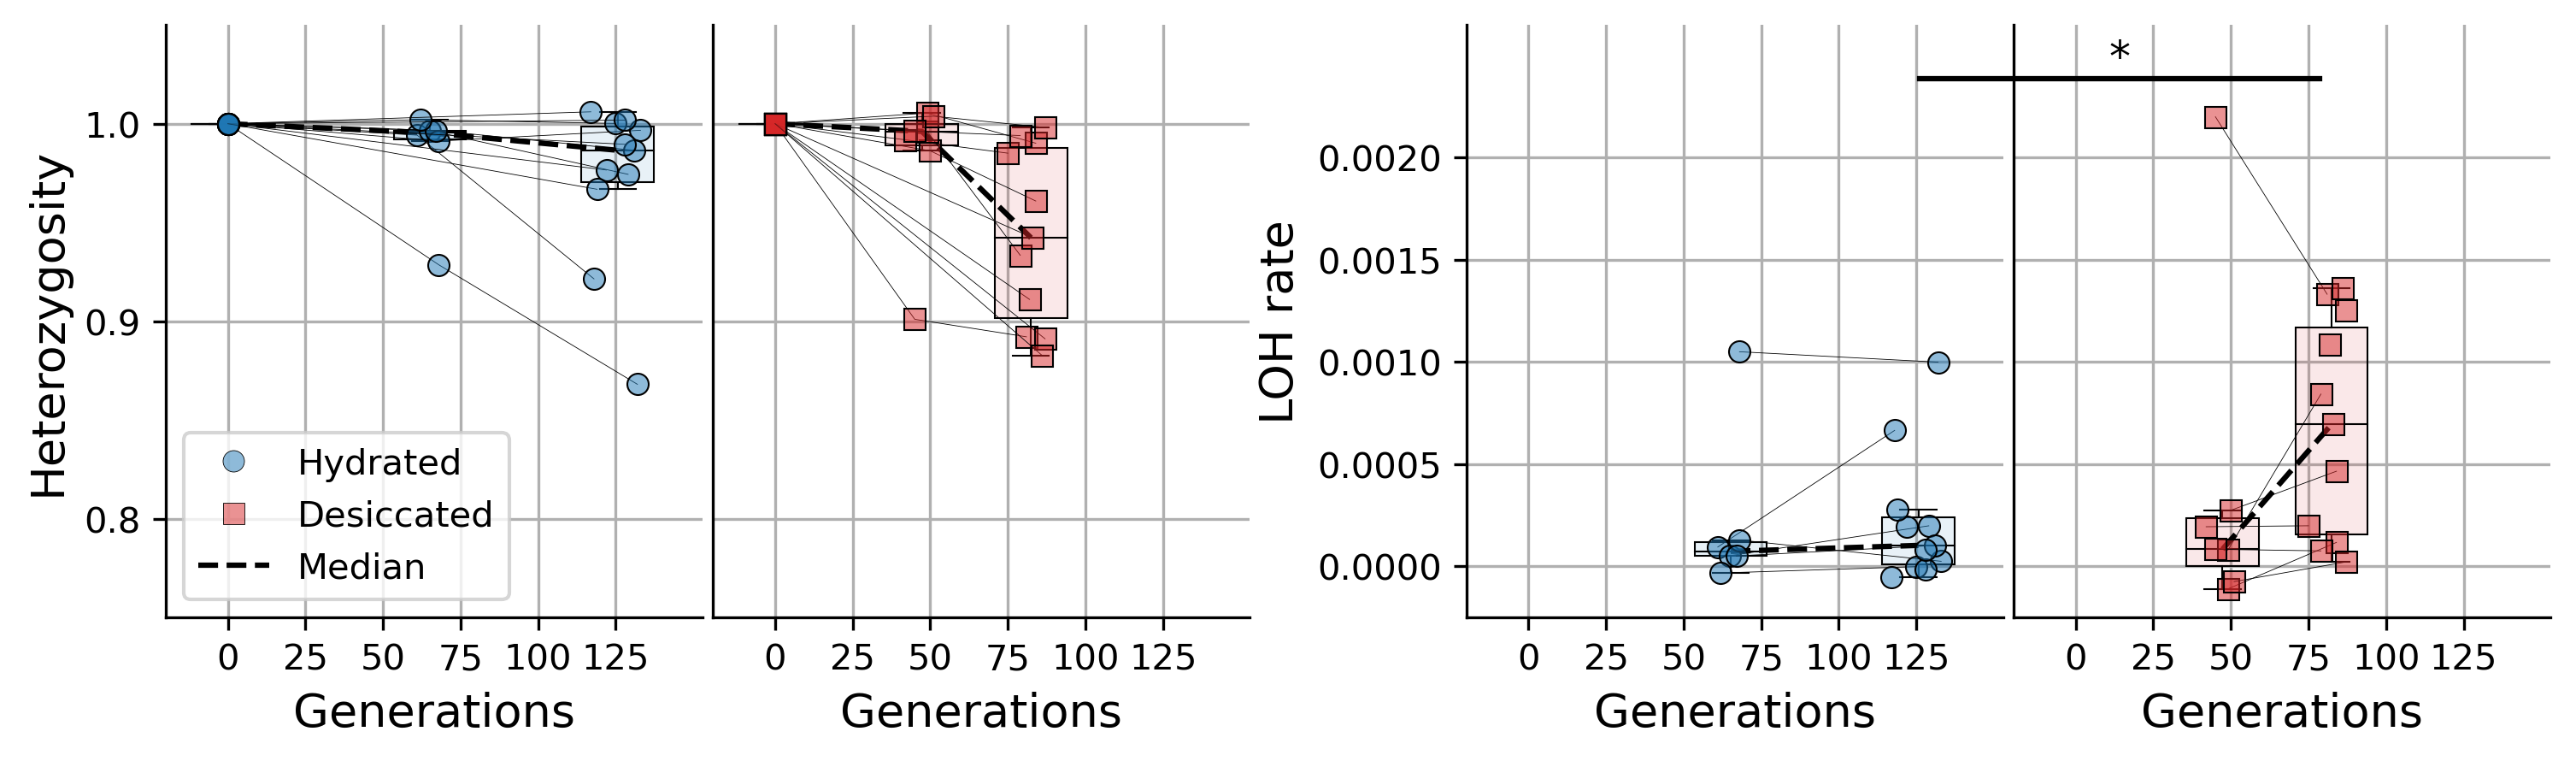

In [76]:
def format_bp(bp, color=0) :
    # General boxplot
    [x.set_facecolor(default_colors[color]+[0.1]) for i, x in enumerate(bp["boxes"])]    
    [x.set_lw(0.5) for i, x in enumerate(bp["boxes"])]
    [x.set_lw(0.5) for i, x in enumerate(bp["caps"])]
    [x.set_lw(0.5) for i, x in enumerate(bp["whiskers"])]
    [x.set_lw(0.5) for i, x in enumerate(bp["fliers"])]
    [x.set_color("k") for i, x in enumerate(bp["medians"])]
    [x.set_lw(0.5) for i, x in enumerate(bp["medians"])]

def get_x_gen(gen, max_gen) :
    return 2 * gen/max_gen # max_gen: x = 2, 0 gen : x=0
    
#fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12,3))

fig = plt.figure(figsize=(12,3), dpi=300)
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0)

left = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.02, hspace=0)
right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], wspace=0.02, hspace=0)

xticks_gens = [0, 25, 50, 75, 100, 125]
xticks = [get_x_gen(x, 133) for x in xticks_gens]

ax = fig.add_subplot(left[0])

midpoint_generations = []
endpoint_generations = []
for sm in H_samples_both :
    midpoint_generations.append(generations[sm+"_50G"])
    endpoint_generations.append(generations[sm])

for sm in H_samples_end :
    endpoint_generations.append(generations[sm])

mean_endpoint_generations = np.mean(endpoint_generations)
mean_midpoint_generations = np.mean(midpoint_generations)

mean_midpoint_generations_xpos = get_x_gen(mean_midpoint_generations, 133) # max x gen in H samples
mean_endpoint_generations_xpos = get_x_gen(mean_endpoint_generations, 133) # max x gen in H samples

bp = ax.boxplot([1.0, H_mid, H_end+H_end_only], positions=[0, mean_midpoint_generations_xpos,mean_endpoint_generations_xpos], patch_artist=True, showfliers=False, zorder=2, widths=[0.35, 0.35, 0.35]) #, showextrema=False)
format_bp(bp, color=0)

ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks_gens])
ax.set_xlabel("Generations", fontsize=13)

ax.set_ylabel("Heterozygosity", fontsize=13)
ax.grid(axis="both", zorder=1)

for sm, y1, y2 in zip(H_samples_both, H_mid, H_end) :
    
    x1 = get_x_gen(generations[sm+"_50G"], 133) # max gen hydrated : 
    x2 = get_x_gen(generations[sm], 133)
    
    ax.plot([0, x1, x2], [1.0, y1, y2], marker="o", ms=6, mfc=default_colors[0]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)
    
for sm, y1 in zip(H_samples_end, H_end_only) :
    x1 = get_x_gen(generations[sm], 133)
    ax.plot([0,x1], [1.0, y1], marker="o", ms=6, mfc=default_colors[0]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)

ax.plot([0,mean_midpoint_generations_xpos,mean_endpoint_generations_xpos], [1.0, np.median(H_mid), np.median(H_end+H_end_only)], linestyle="dashed", lw=1.5, color="k")
ax.set_xlim(-0.3,2.3)

ax.spines[['right', 'top']].set_visible(False)

ax.set_ylim(0.75, 1.05)
ax.set_yticks([0.8,0.9,1.0])
#ax.set_title("Hydrated samples")



custom_lines = [
    Line2D([0], [0], lw=0, marker="o", ms=6, mfc=default_colors[0]+[0.5], mew=0.2, mec="k", label="Hydrated"),
    Line2D([0], [0], lw=0, marker="s", ms=6, mfc=default_colors[3]+[0.5], mew=0.2, mec="k", label="Desiccated"),
    Line2D([0], [0], lw=1.5, marker=None, color="k", linestyle="dashed", label="Median")
]

ax.legend(handles=custom_lines, loc="lower left", ncol=1, fontsize=10, frameon=True) #, bbox_to_anchor=(0.5,-0.02), ncol=2)




#############################
ax = fig.add_subplot(left[1]) # HETEROZYGOSITY IN DESICCATED

midpoint_generations = []
endpoint_generations = []
for sm in D_samples_both :
    midpoint_generations.append(generations[sm+"_50G"])
    endpoint_generations.append(generations[sm])

for sm in D_samples_end :
    endpoint_generations.append(generations[sm])

mean_endpoint_generations = np.mean(endpoint_generations)
mean_midpoint_generations = np.mean(midpoint_generations)

mean_midpoint_generations_xpos = get_x_gen(mean_midpoint_generations, 133) # max x gen in H samples
mean_endpoint_generations_xpos = get_x_gen(mean_endpoint_generations, 133) # max x gen in H samples

bp = ax.boxplot([1.0, D_mid, D_end+D_end_only], positions=[0, mean_midpoint_generations_xpos, mean_endpoint_generations_xpos], patch_artist=True, showfliers=False, zorder=2, widths=[0.35, 0.35, 0.35]) #, showextrema=False)
format_bp(bp, color=3)

for sm, y1, y2 in zip(D_samples_both, D_mid, D_end) :
    
    x1 = get_x_gen(generations[sm+"_50G"], 133) # max gen hydrated : 
    x2 = get_x_gen(generations[sm], 133)
    
    ax.plot([0,x1,x2], [1.0, y1, y2], marker="s", ms=6, mfc=default_colors[3]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)
    
for sm, y1 in zip(D_samples_end, D_end_only) :
    x1 = get_x_gen(generations[sm], 133)
    ax.plot([0, x1], [1.0, y1], marker="s", ms=6, mfc=default_colors[3]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)

ax.plot([0, mean_midpoint_generations_xpos, mean_endpoint_generations_xpos], [1.0, np.median(D_mid), np.median(D_end+D_end_only)], linestyle="dashed", lw=1.5, color="k")

ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(-0.3,2.3)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks_gens])
ax.set_xlabel("Generations", fontsize=13)

ax.tick_params(axis="y", length=0) # y tick length = 0
ax.set_ylim(0.75, 1.05)
yticks = [0.8,0.9,1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(["" for y in yticks])

ax.grid(axis="both", zorder=1)



#############################
ax = fig.add_subplot(right[0]) # LOH RATE IN HYDRATED SAMPLES

midpoint_generations = []
endpoint_generations = []
for sm in H_samples_both :
    midpoint_generations.append(generations[sm+"_50G"])
    endpoint_generations.append(generations[sm])

for sm in H_samples_end :
    endpoint_generations.append(generations[sm])

mean_endpoint_generations = np.mean(endpoint_generations)
mean_midpoint_generations = np.mean(midpoint_generations)

mean_midpoint_generations_xpos = get_x_gen(mean_midpoint_generations, 133) # max x gen in H samples
mean_endpoint_generations_xpos = get_x_gen(mean_endpoint_generations, 133) # max x gen in H samples

bp = ax.boxplot([H_mid_rate, H_end_rate+H_end_only_rate], positions=[mean_midpoint_generations_xpos,mean_endpoint_generations_xpos], patch_artist=True, showfliers=False, zorder=2, widths=[0.35, 0.35]) #, showextrema=False)
format_bp(bp, color=0)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks_gens])
ax.set_xlabel("Generations", fontsize=13)
ax.grid(axis="both", zorder=1)
ax.set_ylabel("LOH rate", fontsize=13)

for sm, y1, y2 in zip(H_samples_both, H_mid_rate, H_end_rate) :
    
    x1 = get_x_gen(generations[sm+"_50G"], 133) # max gen hydrated : 
    x2 = get_x_gen(generations[sm], 133)
    
    ax.plot([x1,x2], [y1, y2], marker="o", ms=6, mfc=default_colors[0]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)
    
for sm, y1 in zip(H_samples_end, H_end_only_rate) :
    x1 = get_x_gen(generations[sm], 133)
    ax.plot([x1], [y1], marker="o", ms=6, mfc=default_colors[0]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)

ax.plot([mean_midpoint_generations_xpos,mean_endpoint_generations_xpos], [np.median(H_mid_rate), np.median(H_end_rate+H_end_only_rate)], linestyle="dashed", lw=1.5, color="k")
ax.set_xlim(-0.3,2.3)
ax.set_ylim(-0.25e-3, 2.65e-3)
yticks = np.arange(0, 2.49e-3, 0.5e-3)
ax.set_yticks(yticks)

ax.spines[['right', 'top']].set_visible(False)


#############################
ax = fig.add_subplot(right[1]) # LOH RATE IN D SAMPLES

midpoint_generations = []
endpoint_generations = []
for sm in D_samples_both :
    midpoint_generations.append(generations[sm+"_50G"])
    endpoint_generations.append(generations[sm])

for sm in D_samples_end :
    endpoint_generations.append(generations[sm])

mean_endpoint_generations = np.mean(endpoint_generations)
mean_midpoint_generations = np.mean(midpoint_generations)

mean_midpoint_generations_xpos = get_x_gen(mean_midpoint_generations, 133) # max x gen in H samples
mean_endpoint_generations_xpos = get_x_gen(mean_endpoint_generations, 133) # max x gen in H samples

bp = ax.boxplot([D_mid_rate, D_end_rate+D_end_only_rate], positions=[mean_midpoint_generations_xpos,mean_endpoint_generations_xpos], patch_artist=True, showfliers=False, zorder=2, widths=[0.35, 0.35]) #, showextrema=False)
format_bp(bp, color=3)
ax.set_xticks(xticks)
ax.tick_params(axis="y", length=0)
ax.set_xticklabels([str(x) for x in xticks_gens])
ax.set_xlabel("Generations", fontsize=13)
ax.grid(axis="both", zorder=1)
#ax.set_ylabel("LOH rate", fontsize=13)

for sm, y1, y2 in zip(D_samples_both, D_mid_rate, D_end_rate) :
    
    x1 = get_x_gen(generations[sm+"_50G"], 133) # max gen hydrated : 
    x2 = get_x_gen(generations[sm], 133)
    
    ax.plot([x1,x2], [y1, y2], marker="s", ms=6, mfc=default_colors[3]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)
    
for sm, y1 in zip(D_samples_end, D_end_only_rate) :
    x1 = get_x_gen(generations[sm], 133)
    ax.plot([x1], [y1], marker="s", ms=6, mfc=default_colors[3]+[0.5], mec="k", mew=0.5, lw=0.2, color="k", zorder=5)

ax.plot([mean_midpoint_generations_xpos,mean_endpoint_generations_xpos], [np.median(D_mid_rate), np.median(D_end_rate+D_end_only_rate)], linestyle="dashed", lw=1.5, color="k")
ax.set_xlim(-0.3,2.3)

ax.spines[['right', 'top']].set_visible(False)

ax.set_ylim(-0.25e-3, 2.65e-3)
yticks = np.arange(0, 2.49e-3, 0.5e-3)
ax.set_yticks(yticks)
ax.set_yticklabels(["" for y in yticks])

plt.subplots_adjust(wspace=0.015, hspace=0.015)


### Stats
line = Line2D([0.695, 0.825], [0.81, 0.81], transform=fig.transFigure, color="k")
fig.lines.append(line)
fig.text(x=0.695+(0.825-0.695)/2, y=0.81, s="*", va="bottom", ha="center", fontsize=12)

#line = Line2D([0.63, 0.63, 0.792, 0.792], [0.8, 0.81, 0.81, 0.8], transform=fig.transFigure, color="k")
#fig.lines.append(line)
#fig.text(x=0.63+(0.792-0.63)/2, y=0.8, s="***", va="bottom", ha="center")

#ax.text(x=1.08, y=0.728, s="* low coverage", fontsize=9)
    
plt.show()